In [1]:
import pynucastro

In [2]:
rates = ["p-p-d-ec",
         "d-pg-he3-de04",
         "he3-he3pp-he4-nacr"]

In [3]:
net = pynucastro.RateCollection(rates)

In [4]:
print(net.network_overview())

p
  consumed by:
     p + p --> d
     p + p --> d
     d + p --> he3
  produced by:
     he3 + he3 --> p + p + he4

d
  consumed by:
     d + p --> he3
  produced by:
     p + p --> d
     p + p --> d

he3
  consumed by:
     he3 + he3 --> p + p + he4
  produced by:
     d + p --> he3

he4
  consumed by:
  produced by:
     he3 + he3 --> p + p + he4




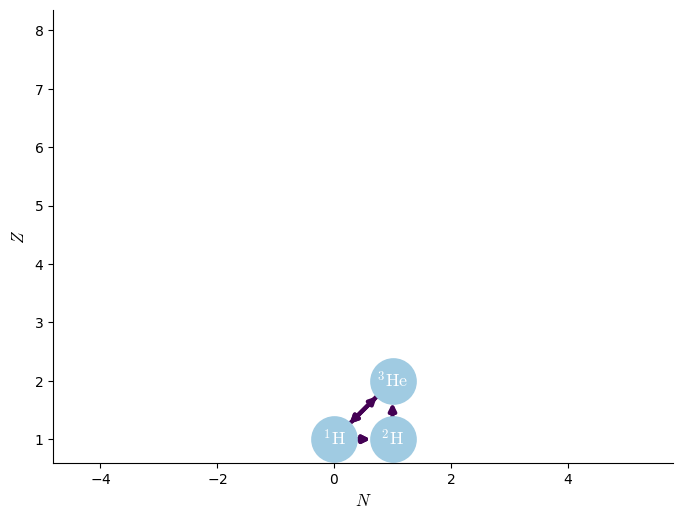

In [5]:
net.plot()

In [6]:
pynet = pynucastro.PythonNetwork(rates)

In [7]:
pynet.write_network()

import numpy as np
from pynucastro.rates import Tfactors
import numba

ip = 0
id = 1
ihe3 = 2
ihe4 = 3
nnuc = 4

A = np.zeros((nnuc), dtype=np.int32)

A[ip] = 1
A[id] = 2
A[ihe3] = 3
A[ihe4] = 4

Z = np.zeros((nnuc), dtype=np.int32)

Z[ip] = 1
Z[id] = 1
Z[ihe3] = 2
Z[ihe4] = 2

names = []
names.append("h1")
names.append("h2")
names.append("he3")
names.append("he4")

@numba.njit()
def ye(Y):
    return np.sum(Z * Y)/np.sum(A * Y)

@numba.njit()
def p_p__d__weak__bet_pos_(tf):
    # p + p --> d
    rate = 0.0
    
    # bet+w
    rate += np.exp(  -34.7863 + -3.51193*tf.T913i + 3.10086*tf.T913
                  + -0.198314*tf.T9 + 0.0126251*tf.T953 + -1.02517*tf.lnT9)
    
    return rate

@numba.njit()
def p_p__d__weak__electron_capture(tf):
    # p + p --> d
    rate = 0.0
    
    #   ecw
    rate += np.exp(  -43.6499 + -0.00246064*tf.T9i + -2.7507*tf.T913i + -0.424877*tf.T913
                  + 0.015987*tf.T9 + -0.000690875*tf.T953 + -0.207625*tf.lnT9)
    
    return rate

@numba.nj